# Example cross-correlation FFS

Calculate all cross-correlation functions (CCFs) between all pairs of detector elements. Check if there is anisotropy in the CCFs caused by active transort. Then fit (i) all CCFs individually, and (ii) with a global fit. Sample: freely diffusing fluorescent beads

Load packages

In [1]:
from brighteyes_ffs.fcs.fcs2corr import fcs_load_and_corr_split as correlate
from brighteyes_ffs.fcs.corr_input_from_kw import get_corr_input
from brighteyes_ffs.fcs.filter_g import good_chunks_from_g_obj as good_chunks_idx
from brighteyes_ffs.fcs.fcs_fit import fcs_fit, make_fit_info_global_fit, read_global_fit_result
from brighteyes_ffs.fcs.fcs_polar import g2flow
from brighteyes_ffs.tools.stokes_einstein import stokes_einstein
import matplotlib.pyplot as plt
import numpy as np

File name and correlation options to calculate. The three 'least intuitive' options that are required are list_of_g, averaging, and list_of_g_out.

**list_of_g** is a list of correlations to calculate. 'crossAll' is a predefined keyword which will calculate all cross-correlations. See documentation for other options.

**averaging** is a list of correlations to average, which can be done for correlations between pairs of detector elements with similar relative positions. E.g., the CCF of elements (18, 2) and the CCF of elements (22, 6) are both corresponding to a vertical shift of -3 units and a horizontal shift of -1 units for the 5x5 array detector. These can be immediataly averaged without saving all individual curves by writing averaging=['18x2+22x6'].

**list_of_g_out** is a list of strings where you can freely choose the names of the averaged correlations. E.g., 'V-3_H-1' can mean the average cross-correlation of all pairs with relative shifts of -3 pixels and -1 pixel in the vertical and horizontal direction, respectively.

For several common correlation modes and detector types, all three options can be retrieved automatically by calling the function get_corr_input(corrtype, det).

In [2]:
file = r'Y:\Data MMS server\FCS_Setup\NIsystem\2025\2025-04-30_beads\01_20nmbeads_488_LP57_y_100_x_100.bin'
corrtype = 'all cross-correlations'
det = 'square 5x5'                   # either 'square 5x5', 'pda-23', 'airyscan 32'
algorithm = 'sparse_matrices'        # 'sparse_matrices' for fast time-domain calculation
accuracy = 20                        # the higher this number, the more points the correlation will have
split = 1                            # split the data in segments of 1 s and calculate the ACF for each segment separately
time_trace = True                    # return the intensity time trace

list_of_g, list_of_g_out, averaging = get_corr_input(corrtype=corrtype, det=det)

## Calculate correlations

In [3]:
G, time_trace = correlate(file, list_of_g=list_of_g, list_of_g_out=list_of_g_out, averaging=averaging, algorithm=algorithm, accuracy=accuracy, split=split, time_trace=time_trace)

+--------------------+
| Loading chunk 1/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 2/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 3/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 4/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 5/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all cros

+---------------------+
| Loading chunk 40/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 41/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 42/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 43/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 44/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calcu

### Plot time-trace

Text(0, 0.5, 'Photon counts per bin')

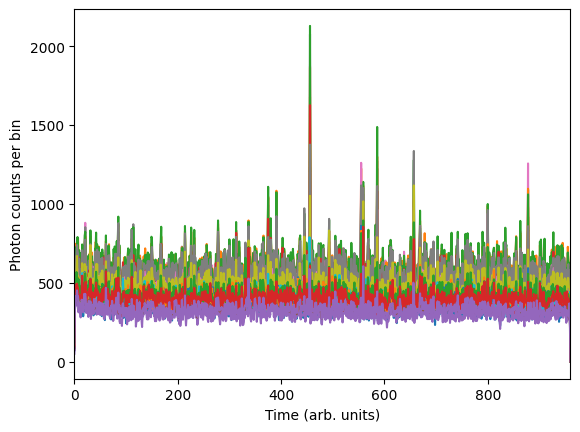

In [4]:
plt.figure()
for i in range(25):
    plt.plot(time_trace[:,i])
plt.xlim([0,960])
plt.xlabel('Time (arb. units)')
plt.ylabel('Photon counts per bin')

### Plot correlations

Text(0, 0.5, 'G')

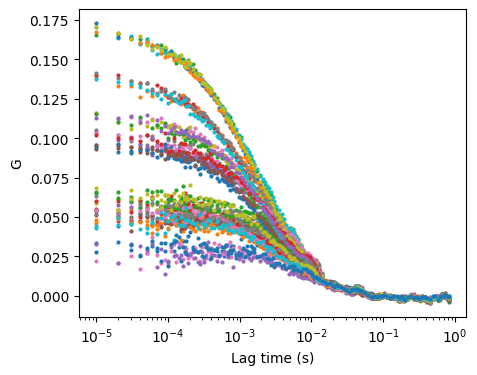

In [5]:
plt.subplots(figsize=(5,4))
for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_average')
    plt.scatter(Gsingle[1:,0], Gsingle[1:,1], s=4, label='chunk ' + str(i))
plt.xscale('log')
plt.xlabel('Lag time (s)')
plt.ylabel('G')

### Plot heat map to check for diffusion anisotropy

Out of all the CCFs calculated, we select the 4 ones corresponding to the cross-correlation between the central element and the four nearest neighbours. We calculate the difference between the CCFs in the horizontal and vertical direction to check for potential anisotropy.

In [6]:
corrs_for_flow = ['V0_H1', 'V-1_H0', 'V0_H-1', 'V1_H0']
corrs, _, _ = G.get_av_corrs(corrs_for_flow, av='_average') # make a 2D array with each column 1 of the 4 correlation curves

z, flow = g2flow(corrs[1:,:], detector='square')
r = flow[1]
u = flow[0]
R = len(z) / 2
phi = np.linspace(0, 2*np.pi, 360)

(np.float64(-9.0), np.float64(189.0), np.float64(-9.0), np.float64(189.0))

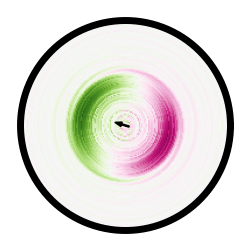

In [7]:
plt.figure(figsize=(3,3))
plt.imshow(np.flipud(z), cmap='PiYG')
plt.arrow(90-(r/2), 90-(u/2), 2*r, 2*u, width=1, head_width=4, color='k', length_includes_head=True)
plt.plot(R*np.cos(phi) + R, R*np.sin(phi)+R, '-', color='k', linewidth=5)
plt.xlim([-0.1*R, 2.1*R])
plt.ylim([-0.1*R, 2.1*R])
plt.axis('off')

The heat map indicates that the diffusion is not isotropic but suggests that there is a flow in the direction of the arrow. Since the sample contains fluorescent beads in suspension, we expect free diffusion. Check if the apparent flow is caused by bad correlation chunks in the data.

### Average over good segments only

Typically, we compare the sum5x5 ACFs for the different chunks, and we give a score to each ACF based on how much it deviates from the average ACF. Here, we do not have a sum5x5, so we choose another ACF, V0_H0, for calculating the score.

In [4]:
idx = good_chunks_idx(G, filt='V0_H0', f_acc=0.66) # use 'V0_H0' to find good chunks, and accept 66 percent
G.average_chunks(idx) # average good chunks

### Plot heat map for filtered data

In [9]:
corrs_for_flow = ['V0_H1', 'V-1_H0', 'V0_H-1', 'V1_H0']
corrs, _, _ = G.get_av_corrs(corrs_for_flow, av='_averageX') # _average_X contains the average of the good chunks only

z, flow = g2flow(corrs[1:,:], detector='square')
r = flow[1]
u = flow[0]
R = len(z) / 2

(np.float64(-9.0), np.float64(189.0), np.float64(-9.0), np.float64(189.0))

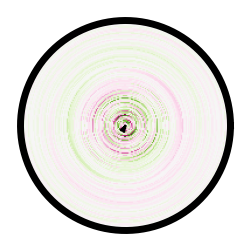

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(np.flipud(z), cmap='PiYG')
plt.arrow(90-(r/2), 90-(u/2), 2*r, 2*u, width=1, head_width=4, color='k', length_includes_head=True)
plt.plot(R*np.cos(phi) + R, R*np.sin(phi)+R, '-', color='k', linewidth=5)
plt.xlim([-0.1*R, 2.1*R])
plt.ylim([-0.1*R, 2.1*R])
plt.axis('off')

Removing the artifacts has removed the apparent flow. Now we can fit the correlation curves.

## Fit correlations

### Fit all correlations individually

For fitfun = 'fcs_fit_dualfocus', the order of the parameters for fitting is
* c: emitter concentration [/um^3]
* D: diffusion coefficient [um^2/s]
* w0: beam waist [nm]
* SF: shape factor [dim.less]
* rho_x, rho_y: distance in x,y direction between each pair of detector elements [nm]
* v_x, v_y: flow speed in x,y direction [um/s]
* offset

In [5]:
from brighteyes_ffs.fcs.fcs_fit import fcs_fit_dualfocus as my_fit_fun

In [6]:
start_idx = 2 # start index of the fit
stop_idx = 141 # stop index

rho_x = [0.0, -75.0, 0.0, 75.0, -150., -75.0, 0.0, 75.0, 150.0, -225., -150., -75.0, 0.0, 75.0, 150.0, 225.0, -300., -225., -150., -75.0, 0.0, 75.0, 150.0, 225.0, 300.0, -225., -150., -75.0, 0.0, 75.0, 150.0, 225.0, -150., -75.0, 0.0, 75.0, 150.0, -75.0, 0.0, 75.0, 0.0]
rho_y = [-300., -225., -225., -225., -150., -150., -150., -150., -150., -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 150.0, 150.0, 150.0, 150.0, 150.0, 225.0, 225.0, 225.0, 300.0]

fitresults = []
for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    Gexp = Gsingle[start_idx:stop_idx,1]
    tau = Gsingle[start_idx:stop_idx,0]
    fitfun = my_fit_fun
    # [c, D, w2 for all, SF for all, rhox for all, rhoy for all, vx, vy, offset for all]
    fit_info = np.asarray([True, True, False, False, False, False, False, False, False]) # use 1 for parameters that have to be fitted, 0 otherwise
    param = np.asarray([1, 1, 318, 5.0, rho_x[i], rho_y[i], 0, 0, 0])
    lBounds = np.asarray([0, 0.001, 0.05, 0.0, -1e6, -1e6, -1e9, -1e9, -100.0]) # the lower bounds for the fit parameters
    uBounds = np.asarray([1e6, 1e3, 1e4, 1e6, 1e6, 1e6, 1e9, 1e9, 1e6]) # the upper bounds for the fit parameters
    fitresult = fcs_fit(Gexp, tau, fitfun, fit_info, param, lBounds, uBounds, plotInfo=-1)
    fitresults.append(fitresult)

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


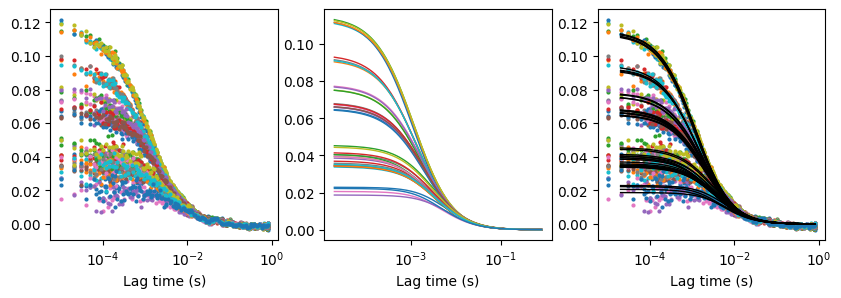

In [7]:
f, axs = plt.subplots(1, 3, figsize=(10,3))
for i, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    fitresult = fitresults[i]
    axs[1].plot(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1]-fitresult.fun, linewidth=1)
    axs[0].scatter(Gsingle[1:,0], Gsingle[1:,1], s=4)
    axs[2].plot(Gsingle[start_idx:stop_idx,0], Gsingle[start_idx:stop_idx,1]-fitresult.fun, c='k', linewidth=1)
    axs[2].scatter(Gsingle[1:,0], Gsingle[1:,1], s=4)

for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Lag time (s)')

In [8]:
fitresults_D = [fitresults[i].x[1] for i in range(len(list_of_g_out))]
fitresults_N = [fitresults[i].x[0] for i in range(len(list_of_g_out))]
print(f"N = {np.mean(fitresults_N):.2f} +/- {np.std(fitresults_N):.2f}")
print(f"D = {np.mean(fitresults_D):.2f} +/- {np.std(fitresults_D):.2f} um^2/s")

T = 293  # temperature in K
visc = 1e-3  # viscosity in Pa.s
D = np.mean(fitresults_D)
diameter = 1e9 * stokes_einstein(1e-12 * D, T, visc)
print(f"--> diameter: {diameter:.2f} nm")

N = 13.25 +/- 3.57
D = 16.27 +/- 3.73 um^2/s
--> diameter: 26.39 nm


### Global fit

Theoretically, a global fit can fit simultaneously D, v, w0, and N

In [9]:
# order of parameters:     N      D      w0     SF     rhox   rhoy   vx     vy     offset
fit_info     = np.asarray([True,  True,  True,  False, False, False, False, False, False]) # should the parameter be fitted?
global_param = np.asarray([True,  True,  False, False, False, False, True,  True,  False]) # should the parameter be the same for every curve?
lbounds      = np.asarray([1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12]) # lower bounds in case of fit
ubounds      = np.asarray([1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12])  # upper bounds in case of fit

# starting values for w0 for each of the 41 curves. Note: if this is a fit parameter, it may be set to any reasonable starting value
w0_all       = np.asarray([534.9, 520.5, 433.0, 436.3, 461.2, 377.4, 342.4, 351.7, 410.4, 449.8, 368.2, 328.2, 307.6, 313.4, 346.7, 455.0, 228.7, 437.4, 337.4, 307.9, 307.1, 308.1, 337.8, 431.3, 644.0, 462.3, 342.3, 317.6, 310.5, 326.4, 368.7, 466.6, 414.4, 360.5, 351.3, 368.3, 443.6, 484.8, 437.7, 498.3, 612.9])

param = np.zeros((len(fit_info), len(list_of_g_out)))
for i, corr in enumerate(list_of_g_out):
    param[:, i] = np.asarray([10, 10, w0_all[i], 5.0, np.sqrt(rho_x[i]**2+rho_y[i]**2), 0, 0, 0, 0]) # starting values

G_all, tau, G_std = G.get_av_corrs(list_of_g_out)

fitresult = fcs_fit(G_all[start_idx:stop_idx,:], tau[start_idx:stop_idx], my_fit_fun, fit_info, param, lbounds, ubounds, plotInfo=-1, global_param=global_param, weights=1)

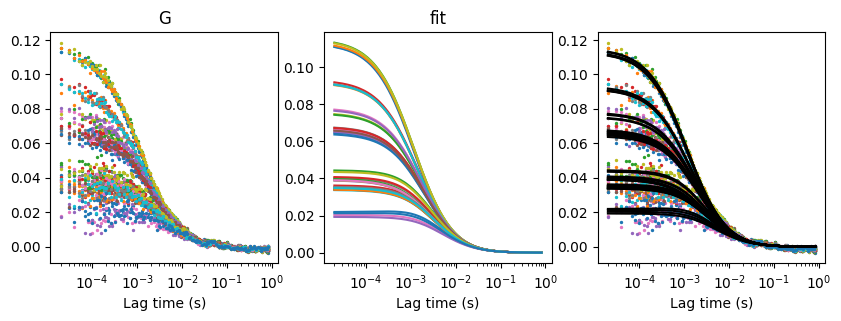

In [16]:
f, axs = plt.subplots(1, 3, figsize=(10,3))
for f, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    axs[0].scatter(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1], s=2)
    axs[2].scatter(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1], s=2)

for f, corr in enumerate(list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    if Gsingle[start_idx,1]-fitresult.fun[start_idx,f] < 0.01:
        print(corr)
    axs[1].plot(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1]-fitresult.fun[:,f])
    axs[2].plot(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1]-fitresult.fun[:,f], 'k')

titles = ['G', 'fit', '']
for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_title(titles[i])

In [17]:
print(f"N = {fitresult.x[0,0]:.2f}")
print(f"D = {fitresult.x[1,0]:.2f} um^2/s")

T = 293  # temperature in K
visc = 1e-3  # viscosity in Pa.s
D = fitresult.x[1,0]
diameter = 1e9 * stokes_einstein(1e-12 * D, T, visc)
print(f"--> diameter: {diameter:.2f} nm")

N = 13.63
D = 12.18 um^2/s
--> diameter: 35.25 nm


## Use all cross-correlations without averaging over different xcorrs

In [17]:
G, time_trace = correlate(file, list_of_g=list_of_g, averaging=None, algorithm=algorithm, accuracy=accuracy, split=split, time_trace=True)
G.average_chunks(idx) # average good chunks

+--------------------+
| Loading chunk 1/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 2/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 3/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 4/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+--------------------+
| Loading chunk 5/60 |
+--------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all cros

+---------------------+
| Loading chunk 40/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 41/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 42/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 43/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calculating all crosscorrelations with sparse matrices algorithm
+---------------------+
| Loading chunk 44/60 |
+---------------------+
data table: (100000, 2)
Converting data to counts
Done.
     --> crossAll: Calcu

In [18]:
from brighteyes_ffs.fcs.distance2detelements import distance2detelements

In [19]:
rho_all = []
for i in range(25):
    for j in range(25):
        rho_all.append(75*distance2detelements(i, j))

In [20]:
# order of parameters:     N      D      w0     SF     rhox   rhoy   vx     vy     offset
fit_info     = np.asarray([True,  True,  True,  False, False, False, False, False, False]) # should the parameter be fitted?
global_param = np.asarray([True,  True,  False, False, False, False, True,  True,  False]) # should the parameter be the same for every curve?
lbounds      = np.asarray([1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12, 1e-12]) # lower bounds in case of fit
ubounds      = np.asarray([1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12,  1e12])  # upper bounds in case of fit

param = np.zeros((len(fit_info), len(G.list_of_g_out)))
for i, corr in enumerate(G.list_of_g_out):
    param[:, i] = np.asarray([10, 10, 250, 5.0, rho_all[i], 0, 0, 0, 0]) # starting values

G_all, tau, weights = G.get_av_corrs(G.list_of_g_out)

fitresult = fcs_fit(G_all[start_idx:stop_idx,:], tau[start_idx:stop_idx], my_fit_fun, fit_info, param,
                    lbounds, ubounds, plotInfo=-1, global_param=global_param, weights=1+0*weights[start_idx:stop_idx,:])

In [21]:
print(f"N = {fitresult.x[0,0]:.2f}")
print(f"D = {fitresult.x[1,0]:.2f} um^2/s")

T = 293  # temperature in K
visc = 1e-3  # viscosity in Pa.s
D = fitresult.x[1,0]
diameter = 1e9 * stokes_einstein(1e-12 * D, T, visc)
print(f"--> diameter: {diameter:.2f} nm")

N = 26.55
D = 13.07 um^2/s
--> diameter: 32.85 nm


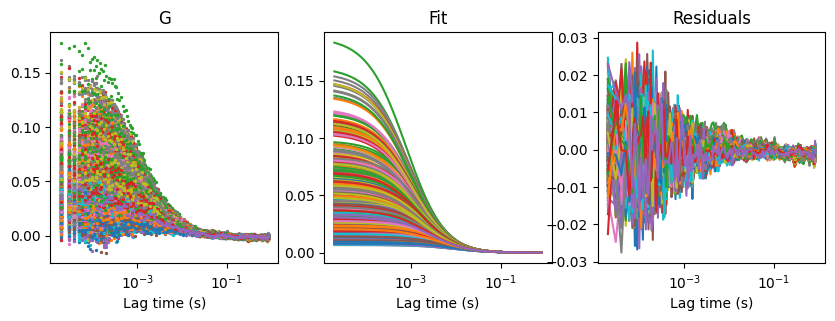

In [22]:
f, axs = plt.subplots(1, 3, figsize=(10,3))
for f, corr in enumerate(G.list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    axs[0].scatter(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1], s=2)
    #axs[2].scatter(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1], s=2)

for f, corr in enumerate(G.list_of_g_out):
    Gsingle = getattr(G, corr + '_averageX')
    axs[1].plot(tau[start_idx:stop_idx], Gsingle[start_idx:stop_idx,1]-fitresult.fun[:,f])
    axs[2].plot(tau[start_idx:stop_idx], fitresult.fun[:,f])

titles = ['G', 'Fit', 'Residuals']
for i in range(3):
    axs[i].set_xscale('log')
    axs[i].set_xlabel('Lag time (s)')
    axs[i].set_title(titles[i])

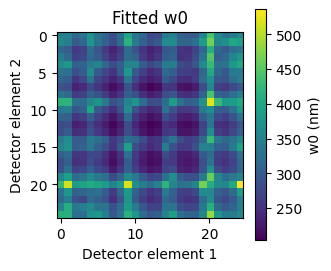

In [23]:
plt.figure(figsize=(3,3))
plt.imshow(np.reshape(fitresult.x[2,:], (25,25)))
plt.xlabel('Detector element 1')
plt.ylabel('Detector element 2')
plt.title('Fitted w0')
plt.colorbar(label='w0 (nm)')